In [1]:
import ray
import numpy as np
import matplotlib.pyplot as plt
from environment import SimpleEnv
from ray_gnn import MPNNModel
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.pre_checks.env import check_env
from ray.rllib.algorithms.ppo import PPOConfig

2023-11-02 11:40:31,788	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-02 11:40:34,656	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-02 11:40:34,794	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


episode: 0
cumulative reward: -10


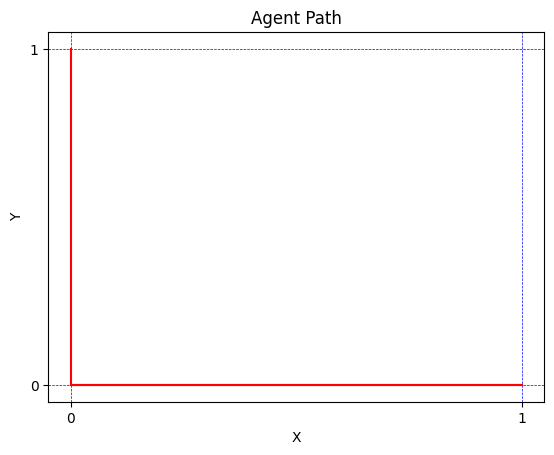

In [2]:
# instantiate the env
length, width, capacity = 2, 2, 2
edge_capacity = np.full((length,width,4),capacity)
macros = []
env= SimpleEnv(length, width, macros, edge_capacity)
num_episodes = 1

# render the env with random moves
for ep in range(num_episodes):
    total_reward = 0
    obs, _ = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, _, info = env.step(action)
        total_reward += reward

        if done:
            break

    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [3]:
# register and check the env
register_env("simple_env", lambda config: SimpleEnv(length, width, macros, edge_capacity))

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

# register the custom model
ModelCatalog.register_custom_model("custom_mpnn", MPNNModel)

2023-11-02 11:40:38,067	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


/home/brucexi2/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:230: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


In [4]:
# config everything
config = (
    PPOConfig()
    .environment(env = "simple_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
    .training(
        model={
            "custom_model": "custom_mpnn",
            "custom_model_config": {  # This is the additional configuration for your model
            "node_features_dim": 2,  # Replace with your actual value
            "edge_features_dim": 1,  # Replace with your actual value
            "action_space_dim": 4,  # Replace with your actual value
            # Add other necessary configurations specific to your model
            }
        },
        _enable_learner_api=False
    )
)
config.rl_module(_enable_rl_module_api=False)
algo = config.build()

2023-11-02 11:40:40,151	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-11-02 11:40:40,152	WARNING algorithm_config.py:2592 -- Setting `exploration_config={'type': 'StochasticSampling'}` because you set `_enable_rl_module_api=False`. This exploration config was restored from a prior exploration config that was overriden when setting `_enable_rl_module_api=True`. This occurs because when RLModule API are enabled, exploration_config can not be set.
2023-11-02 11:40:40,153	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploratio

ValueError: too many values to unpack (expected 2)

: 

In [8]:
# train the policy for 10 iterations, also plot the mean reward vs iteration 
rewards = []
for i in range (10):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
plt.plot(rewards)
plt.show()

episode: 0
cumulative reward: 95


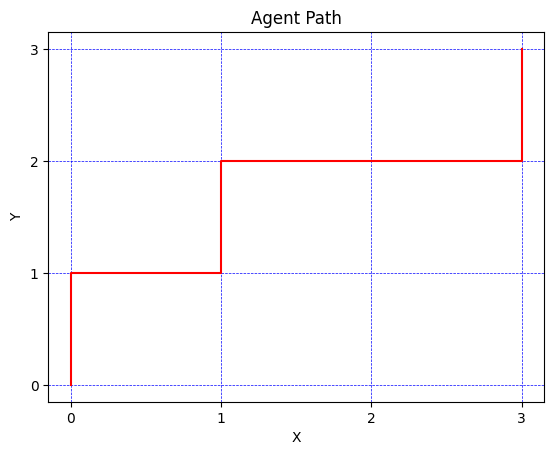

episode: 1
cumulative reward: 95


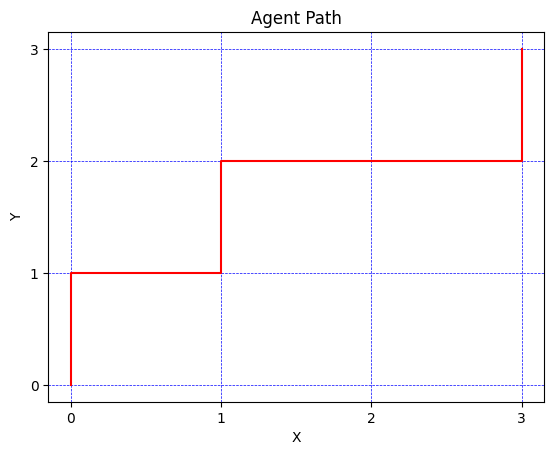

episode: 2
cumulative reward: 95


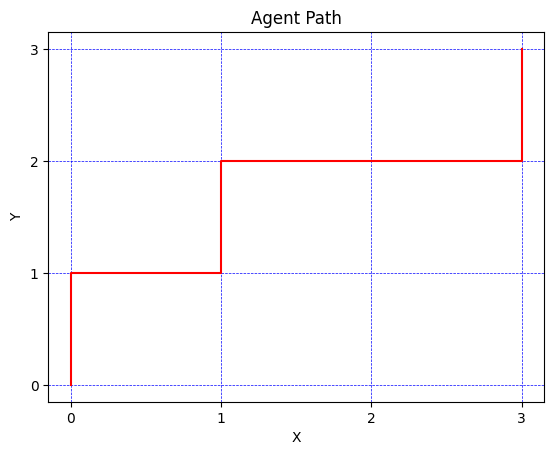

In [9]:
# run inference
num_episodes = 3

for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=False)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [11]:
# release the resources
algo.stop()
ray.shutdown()